
### CD8 LCMV  RNA-Velocity (Alevin-scVelo) - Doublets removal

    Goals:
        1. Detecting potential doublets within the combined data set using SCRAN
            
            Method   I   : based on simulations:  scran::doubletCells()
            Method  II   : based on the distibution of UMI counts within clusters
            Method III   : based on scran::doubleClusters() function
            
        
        2.  Filtering the doublets
        3.  Dimensionality reduction 
        4.  Ploting individual samples/cluster on generated UMAP
        5.  Ploting velocities on the UMAP
        
        



### Section 1: Detecting potential doublets within the the combined data set using SCRAN

In [1]:
#import of python modules
import sys
import scanpy as sc
import numpy as np
import anndata
import rpy2
from rpy2.robjects import r
import anndata2ri
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R
# R libraries
suppressPackageStartupMessages(
    {library(scran)
     library(Rtsne)
     library(scater)
     library(dittoSeq)
    })

## function generate ggplot standard close
library(ggplot2)
ggplotColours <- function(n = 6, h = c(0, 360) + 15){
        if ((diff(h) %% 360) < 1) h[2] <- h[2] - 360/n
        hcl(h = (seq(h[1], h[2], length = n)), c = 100, l = 65)
}

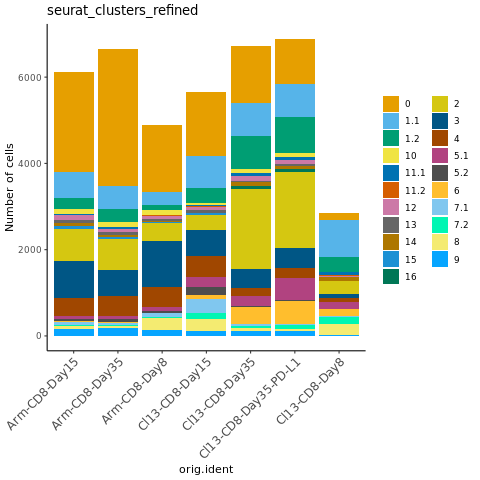

In [3]:
%%R

#Load the sce object containing Zi's counts and logcounts matrices (with umap,pca,metadata), plus our alevin spliced and unspliced matrices
#This was generated Section 1, 

load("/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/CD8_combined_counts_logcounts_alevin_spliced_unspliced_sce.RData")

# Adding the refined clusters (By Zi Agios)
tb=read.csv("/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/200401_Rusty_LCMV_CD8_Seurat_clusters.tsv",sep="\t")
head(tb)
barcodes=tb[,"barcode"]
ix=match(colnames(tmp_sce),barcodes)
tmp_sce$seurat_clusters_refined=as.factor(tb$seurat_cluster[ix])

rawCounts=assay(tmp_sce,"counts") ## Raw counts to be used

## Eplore counts
dittoBarPlot(tmp_sce, "seurat_clusters_refined", group.by = "orig.ident",scale = "count")


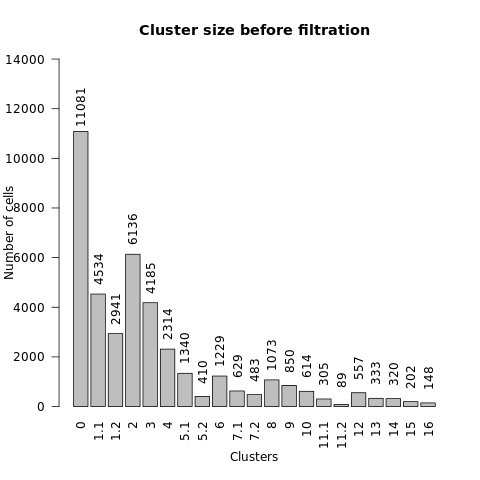

In [4]:
%%R
## Cell counts in each before filtration 
tb=table(tmp_sce$seurat_clusters_refined)
a=barplot(tb,las=2,ylab="Number of cells",xlab="Clusters",main="Cluster size before filtration",ylim=c(0,14000))
text(a[,1],tb+1000, labels=tb,srt = 90)


###   Identifying potential doublet cells using scran

    Method I: function  scran::doubletCells():
    Which Identify potential doublet cells based on simulations of putative doublet expression profiles.
    
     1. Simulate thousands of doublets by adding together two randomly chosen single-cell profiles.
     2. For each original cell, compute the density of simulated doublets in the surrounding neighborhood.
     3. For each original cell, compute the density of other observed cells in the neighborhood.
     4. Return the ratio between the two densities as a “doublet score” for each cell.
    
     ref: https://osca.bioconductor.org/introduction.html


In [5]:
%%R

## computing the doublet scores from raw counts  ( log10(ratio + 1))
dbl.dens <- doubletCells(rawCounts)
summary(dbl.dens)
cat("Ratios:")
str(dbl.dens)
cat("Doublet scores:")
dbl_score=log10(dbl.dens+1)
str(dbl_score)
tmp_sce$dbl_score=dbl_score

Ratios: num [1:39773] 79546 3928 13258 6836 11364 ...
Doublet scores: num [1:39773] 4.9 3.59 4.12 3.83 4.06 ...


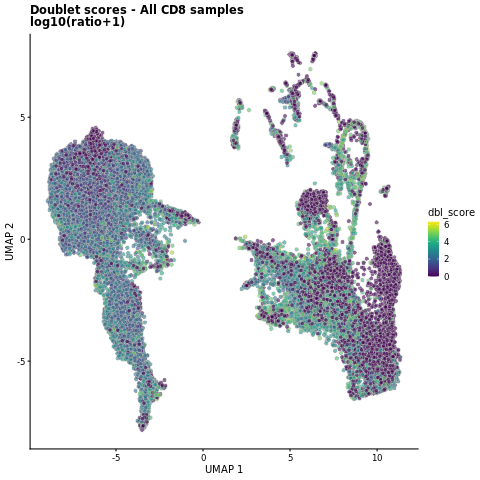

In [6]:
%%R
a=plotUMAP(tmp_sce,colour_by="dbl_score")+ggtitle("Doublet scores - All CD8 samples \nlog10(ratio+1)")
ggsave(a,file="/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/DoubletUMAP_combined.pdf",width=6,height=6) 
a

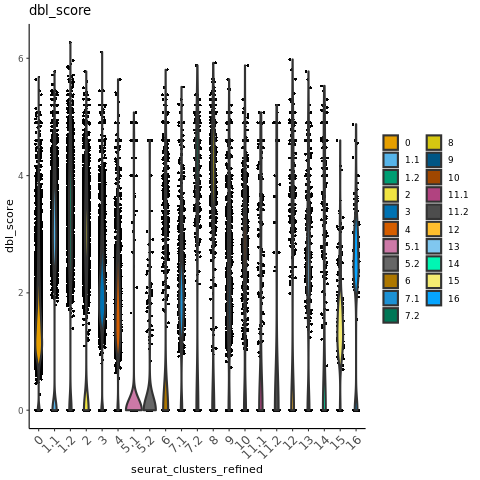

In [7]:
%%R
## doublet score distribution in each cluster
a=dittoPlot(tmp_sce, "dbl_score", group.by = "seurat_clusters_refined")
ggsave(a,file="/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/Doublet_Density_combined_BeforeFilter.pdf",width=12,height=5)
a

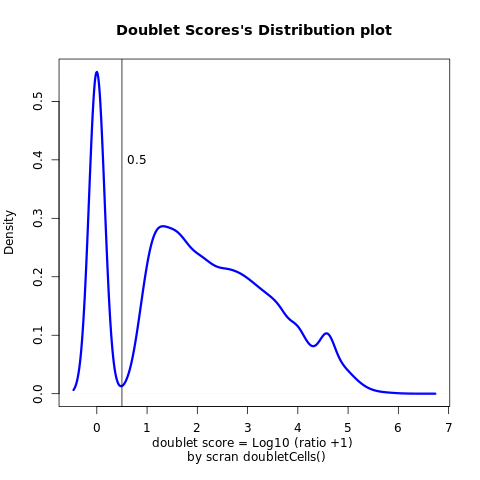

In [8]:

%%R
## Doublet score density plot
plot(density(dbl_score),"Doublet Scores's Distribution plot",xlab="doublet score = Log10 (ratio +1) \n by scran doubletCells()",lwd=3,col="blue")
abline(v=0.5)
text(.8,.4,"0.5")

 ## Method II: Identifying potential doblet cluster based on cluster UMI counts (Tim's suggestion)

    UMI count distribution per cluster
    median/mean/mode (your choice), suitably transformed (log), 
    and exclude clusters whose center of mass in terms of UMI count is >= 1.75x that of the median. 
    

In [10]:
%%R
## Getting distribution totoal Cell UMI counter for ever cluster (log2(counts+1))

sum_per_cell_rawcount=colSums(log2 (rawCounts+1))

##
cls_r=as.character(tmp_sce$seurat_clusters_refined)
cls_r_unique=as.character(sort(as.numeric(unique(cls_r))))
cls_r_unique

 [1] "0"    "1.1"  "1.2"  "2"    "3"    "4"    "5.1"  "5.2"  "6"    "7.1" 
[11] "7.2"  "8"    "9"    "10"   "11.1" "11.2" "12"   "13"   "14"   "15"  
[21] "16"  


In [11]:
%%R
## Density plots (each cluster ) for Total MI per Cell
pdf("/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/cellSums_UMI_Density_cluster.pdf",height=12,width=12)
par(mfrow=c(5,5))
for (cl  in cls_r_unique){
    v=as.numeric(sum_per_cell_rawcount[which(cls_r==cl)])
    plot(density(v),main=cl,lwd=2,xlab="Log2(UMI-count + 1)",xlim=c(0,9000))
    abline(v=median(v),lwd=2,lty=2,col="magenta")
    legend("topright",legend=paste0("median=",round(median(v),1)),col="red")
}
#dev.off()

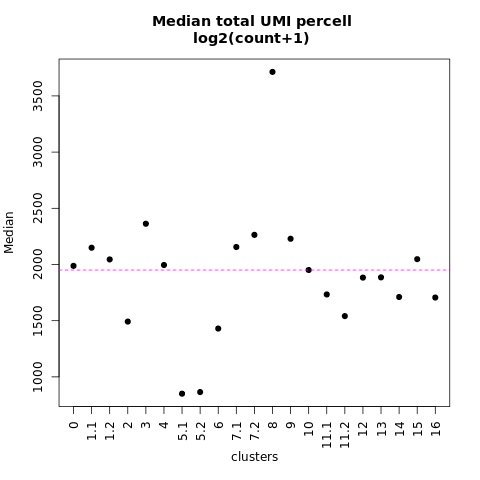

In [12]:
%%R

## Scatterplot of medians (each cluster ) for Total MI per Cell
medians=c()
for (cl  in cls_r_unique){
    v=as.numeric(sum_per_cell_rawcount[which(cls_r==cl)])
    medians=c(medians,median(v))  
}

par(mforw=c(2,1))
plot(medians,main="Median total UMI percell \nlog2(count+1) ",xlab="clusters",xaxt="n",pch=19,ylab="Median")
axis(side=1, at=1:21, labels=cls_r_unique,las=2)
abline(h=median(medians),lty=2,col="magenta")


## Method III:  Doublets using doubletCluster() from scran

function help()

This function detects clusters of doublet cells in a manner similar to the method used by Bach et al. (2017). For each “query” cluster, we examine all possible pairs of “source” clusters, hypothesizing that the query consists of doublets formed from the two sources. If so, gene expression in the query cluster should be strictly intermediate between the two sources after library size normalization.

We apply pairwise t-tests to the normalized log-expression profiles (see normalize) to reject this null hypothesis. This is done by identifying genes that are consistently up- or down-regulated in the query compared to both of the sources. We count the number of genes that reject the null hypothesis at the specified FDR threshold. For each query cluster, the most likely pair of source clusters is that which minimizes the number of significant genes.

Potential doublet clusters are identified using the following characteristics:

Low number of significant genes, i.e., N in the output DataFrame. The threshold can be identified by looking for small outliers in log(N) across all clusters, under the assumption that most clusters are not doublets (and thus should have high N).

A reasonable proportion of cells in the cluster, i.e., prop. This requires some expectation of the doublet rate in the experimental protocol.

Library sizes of the source clusters that are below that of the query cluster, i.e., lib.size* values below unity. This assumes that the doublet cluster will contain more RNA and have more counts than either of the two source clusters.

Another ref: https://osca.bioconductor.org/introduction.html

In [13]:
%%R

dbl.out <- doubletCluster(x=rawCounts,clusters=tmp_sce$seurat_clusters)
a=do.call(cbind,dbl.out@listData[1:8]);  rownames(a)=dbl.out@rownames
a=data.frame(a)
a

   source1 source2    N          best               p.value         lib.size1
15      16       0   10 5830405F06Rik  6.44499160784014e-52 0.668650793650794
0        4      15   17        Eef1a1  0.000260408806169941  1.02717263996252
13      15      12   20          Trdc  7.31311528785588e-86  1.25546637143648
16      14      13   63         Rps12  2.07998811920945e-18 0.921529838443785
10      16      15   72           Myb  4.80056580907189e-97 0.818181818181818
4       15      11  104          Actb   3.0561725412705e-32  1.03443557582668
1        8      16  109          Ccl5  1.88647046157711e-13  2.03588485865496
5       16      14  118         Rpl41  9.33225725301249e-45  2.50661157024793
9       16      15  129          Egr1  5.88264531292603e-73 0.650718729886291
7        8      15  190         Ifit1  7.0469182796366e-162  1.73662188945166
12      14      13  203           Id2  1.58208670454836e-35 0.835575485799701
14      16      11  213          Ppbp  2.07618916986215e-65  1.0

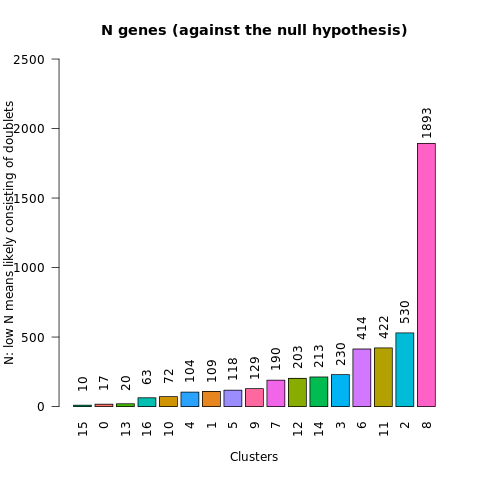

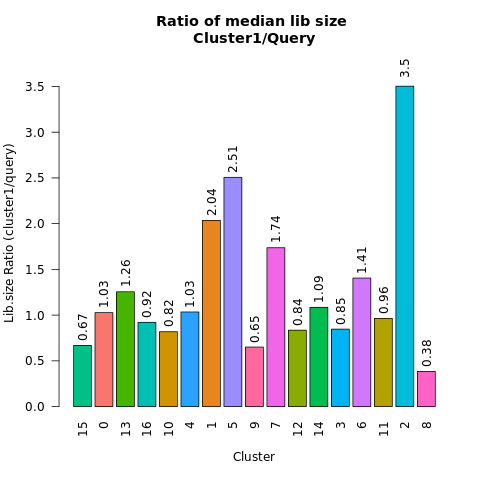

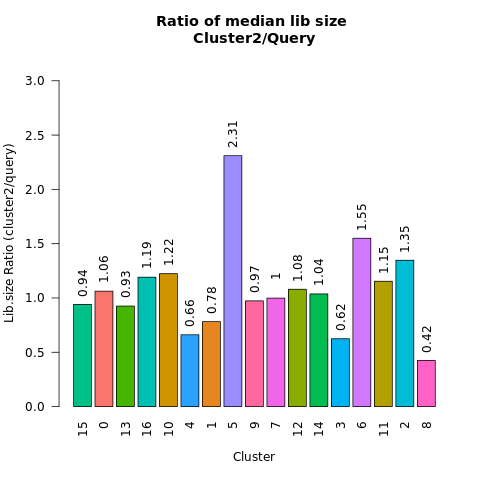

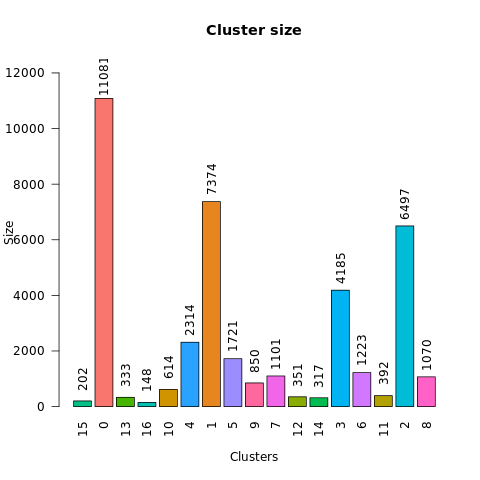

In [14]:

%%R
#(N) number of that are differentially expressed
# N gives evindence against the Null Hypothesis ["cluster consist of doublets"]   i.e cluster with low N genes is likely consisting of doublets
colz=ggplotColours(n = 17);names(colz)=names(table(tmp_sce$seurat_clusters))
colz=colz[rownames(dbl.out)]

b= dbl.out$N;names(b)=rownames(dbl.out)
#par(mfrow=c(1,4))

a=barplot(b,las=2,main="N genes (against the null hypothesis)",ylab="N: low N means likely consisting of doublets",xlab="Clusters",ylim=c(0,2500),col=colz)
text(a[,1],b+150, labels=b,srt = 90)

## Querry Cluster1 Median lib.size ratio
p=dbl.out$lib.size1; names(p)=rownames(dbl.out) 
b=barplot(p,ylim=c(0,3.8),las=2,main="Ratio of median lib size \nCluster1/Query",ylab= "Lib.size Ratio (cluster1/query)",xlab="Cluster",col=colz)
text(b[,1],p+.2, labels=round(p,2),srt = 90)

## Querry Cluster2 Median lib.size ratio
p=dbl.out$lib.size2; names(p)=rownames(dbl.out) 
b=barplot(p,ylim=c(0,3.2),las=2,main="Ratio of median lib size \nCluster2/Query",ylab= "Lib.size Ratio (cluster2/query)",xlab="Cluster",col=colz)
text(b[,1],p+.2, labels=round(p,2),srt = 90)

cs=table(tmp_sce$seurat_clusters)
cs=cs[rownames(dbl.out)] 
a=barplot(cs,las=2,main="Cluster size",ylab="Size",xlab="Clusters",ylim=c(0,12500),col=colz)
text(a[,1],cs+800, labels=cs,srt = 90)


## Removing out doublet based on doublet score computer with Method I : scran::doubletCells()
   Threshold 0.5


In [35]:
%%R
## Removing doublets threshold = 0.5
ix=which(tmp_sce$dbl_score>.5)
length(ix)/length(tmp_sce$dbl_score)
tmp_sce_Dbl=tmp_sce[,ix]
tmp_sce_NoDbl=tmp_sce[,-ix]

In [40]:
### save to disk the sce object (no doublets)
%%R
save(tmp_sce_NoDbl,file="/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/CD8_combined_counts_logcounts_alevin_spliced_unspliced_sce_NoDbl.RData")



 ## Showing individual sample, on the new heatmap, calculating velocity estimates
   Threshold 0.5



In [1]:
#import of python modules
import sys
import numpy as np
import anndata
import rpy2
from rpy2.robjects import r
import anndata2ri
anndata2ri.activate()

%load_ext rpy2.ipython

/primary/projects/mnp/tools/anaconda3/envs/alevin_env2/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
%%R 
#Importing R libraries
suppressPackageStartupMessages({
    library(SummarizedExperiment)
    library(reticulate)
    library(SingleCellExperiment)
    library(scater)
    library(Rtsne)
    library(dittoSeq)
    #library(zellkonverter)
})

In [3]:

%%R
###  Load sce disk the sce object (no doublets)
load("/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/CD8_combined_counts_logcounts_alevin_spliced_unspliced_sce_NoDbl.RData")

In [4]:
%%R
## plot cluster size after Doblet filrtation
#dittoBarPlot(tmp_sce_NoDbl,"seurat_clusters_refined", group.by = "orig.ident",scale = "count")

NULL


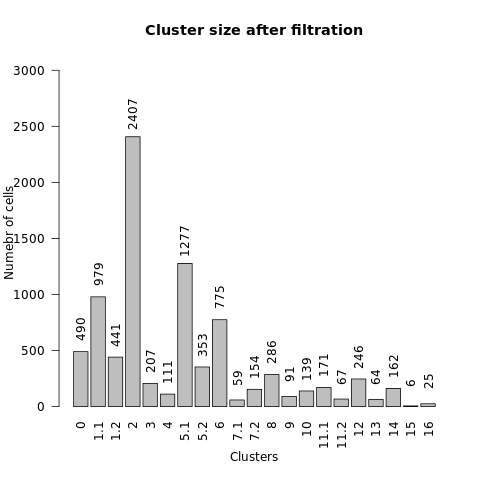

In [5]:
%%R
## Cell counts in each after filtration 
tb=table(tmp_sce_NoDbl$seurat_clusters_refined)
a=barplot(tb,las=2,ylab="Numebr of cells",xlab="Clusters",main="Cluster size after filtration",ylim=c(0,3100))
text(a[,1],tb+200, labels=tb,srt = 90)

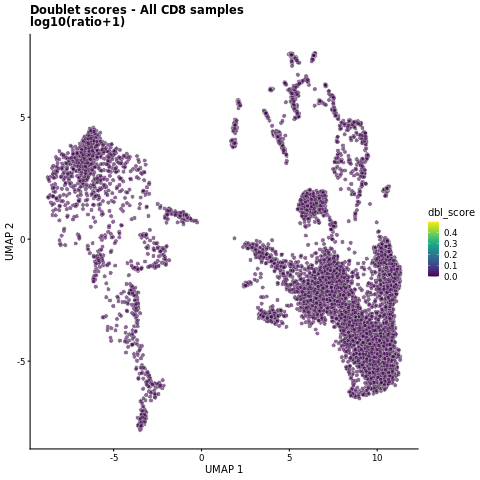

In [6]:

%%R
## Plot doublet scores after filtration
a=plotUMAP(tmp_sce_NoDbl,colour_by="dbl_score")+ggtitle("Doublet scores - All CD8 samples \nlog10(ratio+1)")
#ggsave(a,file="/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/DoubletUMAP_combined_afterFilter.pdf",width=6,height=6) 
a

In [7]:

#import of python modules
import sys
import scanpy as sc
import numpy as np
import anndata
import rpy2
from rpy2.robjects import r
import anndata2ri
anndata2ri.activate()

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [8]:
%%R
# Add factor that shows clusters for individual sample and replacing NAs for other samples names
# Use to visualize each individual group

sampleN_vect=as.character(tmp_sce_NoDbl$orig.identF)
sample_Names=(names(table(sampleN_vect)))
seurat_clusters_refined=as.character(tmp_sce_NoDbl$seurat_clusters_refined)

for (sN in sample_Names){
    
    ixNA=(which(sampleN_vect!=sN))
    
    s1<-sampleN_vect
    s2 <- seurat_clusters_refined
    
    s1[ixNA]=NA
    s2[ixNA]=NA
    
    ## Highliting all individual samples on the Unified UMAP
    
    tmp_sce_NoDbl[[paste0(sN,"_Lbl")]]=as.factor(s1)
    tmp_sce_NoDbl[[paste0(sN,"_seurat_cluster_refined")]]=as.factor(s2)
}

In [9]:
adata = r('as(tmp_sce_NoDbl, "SingleCellExperiment")')
adata

AnnData object with n_obs × n_vars = 8510 × 30436 
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'housekeeping_gene', 'nCount_RNA.log2', 'outlier', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.5', 'seurat_clusters', 'integrated_snn_res.0.5', 'ident', 'orig.identF', 'seurat_clusters_refined', 'dbl_score', 'Arm-CD8-Day15_Lbl', 'Arm-CD8-Day15_seurat_cluster_refined', 'Arm-CD8-Day35_Lbl', 'Arm-CD8-Day35_seurat_cluster_refined', 'Arm-CD8-Day8_Lbl', 'Arm-CD8-Day8_seurat_cluster_refined', 'Cl13-CD8-Day15_Lbl', 'Cl13-CD8-Day15_seurat_cluster_refined', 'Cl13-CD8-Day35_Lbl', 'Cl13-CD8-Day35_seurat_cluster_refined', 'Cl13-CD8-Day35-PD-L1_Lbl', 'Cl13-CD8-Day35-PD-L1_seurat_cluster_refined', 'Cl13-CD8-Day8_Lbl', 'Cl13-CD8-Day8_seurat_cluster_refined'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    layers: 'logcounts', 'spliced', 'unspliced'



### Showing individual sample on the heatmap





In [10]:
# Performe dimentionality reduction UMAP
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/primary/projects/mnp/tools/anaconda3/envs/alevin_env2/lib/python3.7/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


... storing 'orig.ident' as categorical
... storing 'Phase' as categorical
... storing 'RNA_snn_res.0.5' as categorical


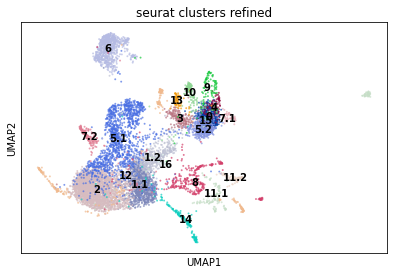

In [11]:
sc.pl.scatter(adata,basis="umap",size=15, alpha=0.7,color="seurat_clusters_refined",legend_loc='on data',save="AllCD8_seurat_clusters_refined_NoDbl_0.5.svg" )

--

    UMAP showing cells from each individual sample highiliting all refined clusters    

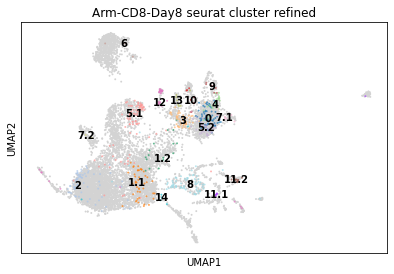

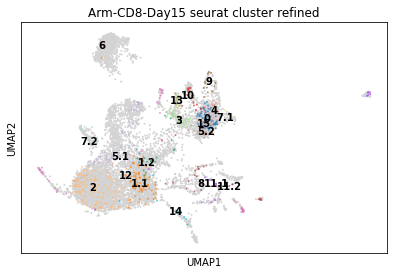

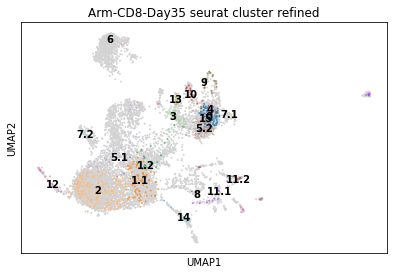

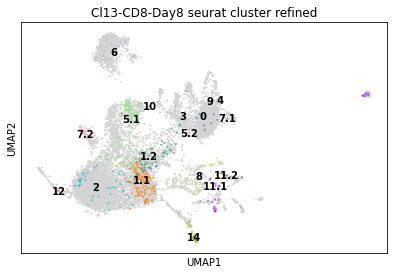

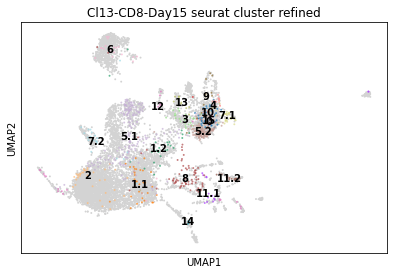

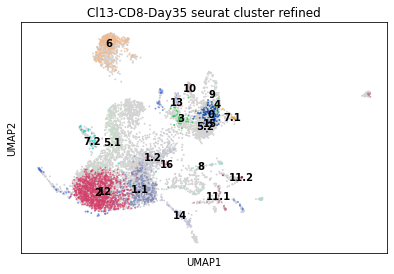

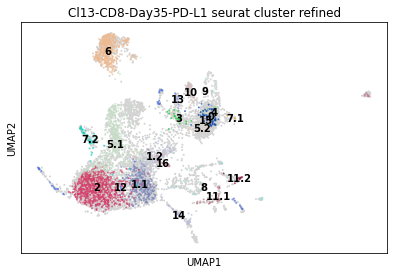

In [12]:
#In color
sc.pl.scatter(adata,basis="umap",size=15, alpha=0.7,color="Arm-CD8-Day8_seurat_cluster_refined",legend_loc='on data')#,save="Arm-CD8-Day8_seurat_cluster_refined.svg")
sc.pl.scatter(adata,basis="umap",size=15, alpha=0.7,color="Arm-CD8-Day15_seurat_cluster_refined",legend_loc='on data')#,save="Arm-CD8-Day15_seurat_cluster_refined.svg")
sc.pl.scatter(adata,basis="umap",size=15, alpha=0.7,color="Arm-CD8-Day35_seurat_cluster_refined",legend_loc='on data')#,save="Arm-CD8-Day35_seurat_cluster_refined.svg")
sc.pl.scatter(adata,basis="umap",size=15, alpha=0.7,color="Cl13-CD8-Day8_seurat_cluster_refined",legend_loc='on data')#,save="Cl13-CD8-Day8_seurat_cluster_refined.svg")
sc.pl.scatter(adata,basis="umap",size=15, alpha=0.7,color="Cl13-CD8-Day15_seurat_cluster_refined",legend_loc='on data')#,save="Cl13-CD8-Day15_seurat_cluster_refined.svg")
sc.pl.scatter(adata,basis="umap",size=15, alpha=0.7,color="Cl13-CD8-Day35_seurat_cluster_refined",legend_loc='on data')#,save="Cl13-CD8-Day35_seurat_cluster_refined.svg")
sc.pl.scatter(adata,basis="umap",size=15, alpha=0.7,color="Cl13-CD8-Day35-PD-L1_seurat_cluster_refined",legend_loc='on data')#,save="Cl13-CD8-Day35-PD-L1_seurat_cluster_refined.svg")

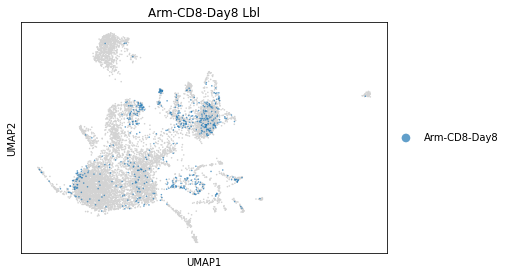

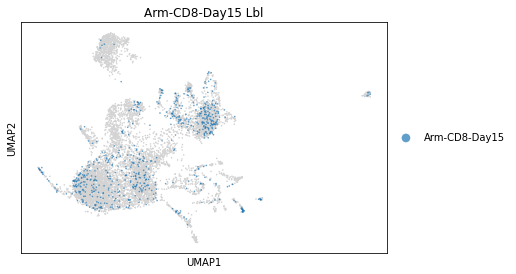

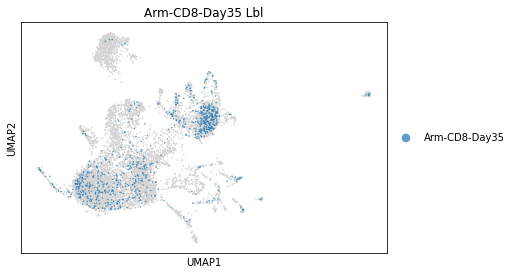

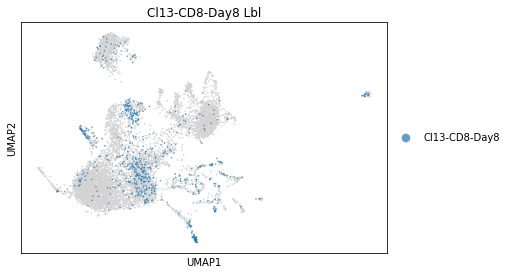

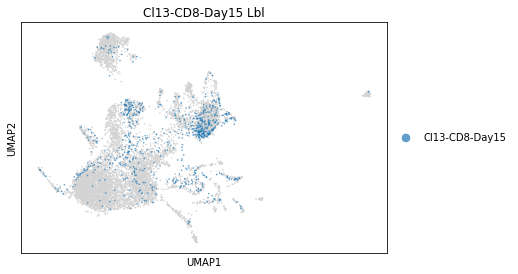

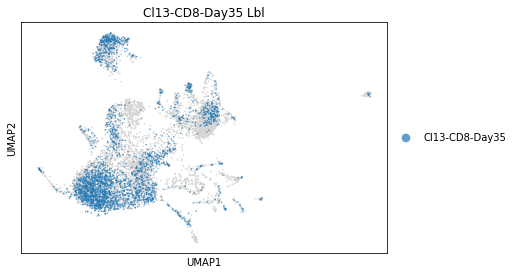

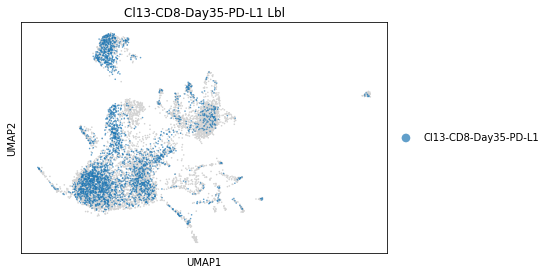

In [13]:
#One color
sc.pl.scatter(adata,basis="umap",color ="Arm-CD8-Day8_Lbl",size=10, alpha=0.7)
sc.pl.scatter(adata,basis="umap",color ="Arm-CD8-Day15_Lbl",size=10, alpha=0.7)
sc.pl.scatter(adata,basis="umap",color ="Arm-CD8-Day35_Lbl",size=10, alpha=0.7)
sc.pl.scatter(adata,basis="umap",color ="Cl13-CD8-Day8_Lbl",size=10, alpha=0.7)
sc.pl.scatter(adata,basis="umap",color ="Cl13-CD8-Day15_Lbl",size=10, alpha=0.7)
sc.pl.scatter(adata,basis="umap",color ="Cl13-CD8-Day35_Lbl",size=10, alpha=0.7)
sc.pl.scatter(adata,basis="umap",color ="Cl13-CD8-Day35-PD-L1_Lbl",size=10, alpha=0.7)



### Section 3:  Computing velocity vectors from the  obtained counts (splice / unspliced ) - combined sample

In [14]:
#Using scVelo to select variable genes
import scvelo as scv
import matplotlib
import pandas as pd

matplotlib.use('AGG')
scv.logging.print_version()
scv.settings.set_figure_params('scvelo')  # for beautified visualization
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
%matplotlib inline


Running scvelo 0.2.2.dev3+gdfb4d42 (python 3.7.7) on 2020-08-14 10:05.


In [15]:
scv.utils.show_proportions(adata)

Abundance of ['spliced', 'unspliced']: [0.15 0.85]


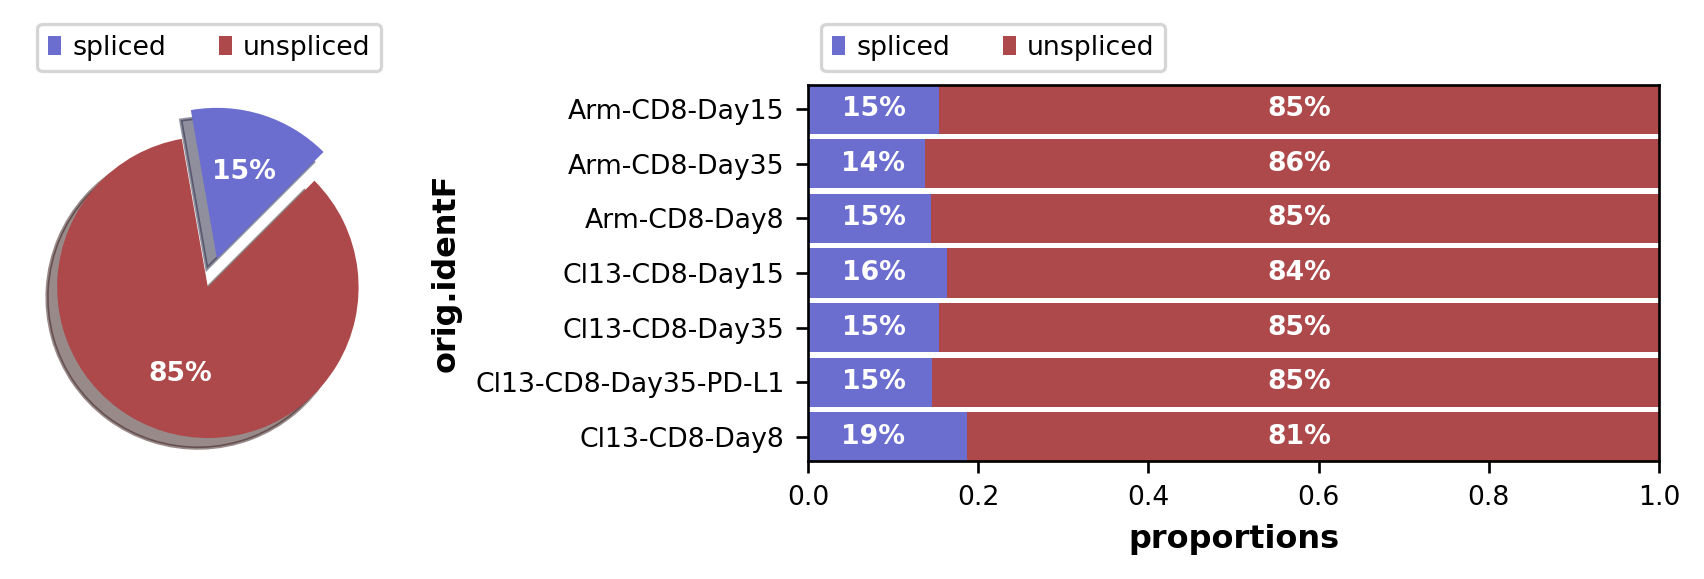

In [16]:
## Percentage of spliced/unspliced transcripts by samples
%matplotlib inline
scv.pl.proportions(adata,groupby='orig.identF',dpi=120,fontsize=8)


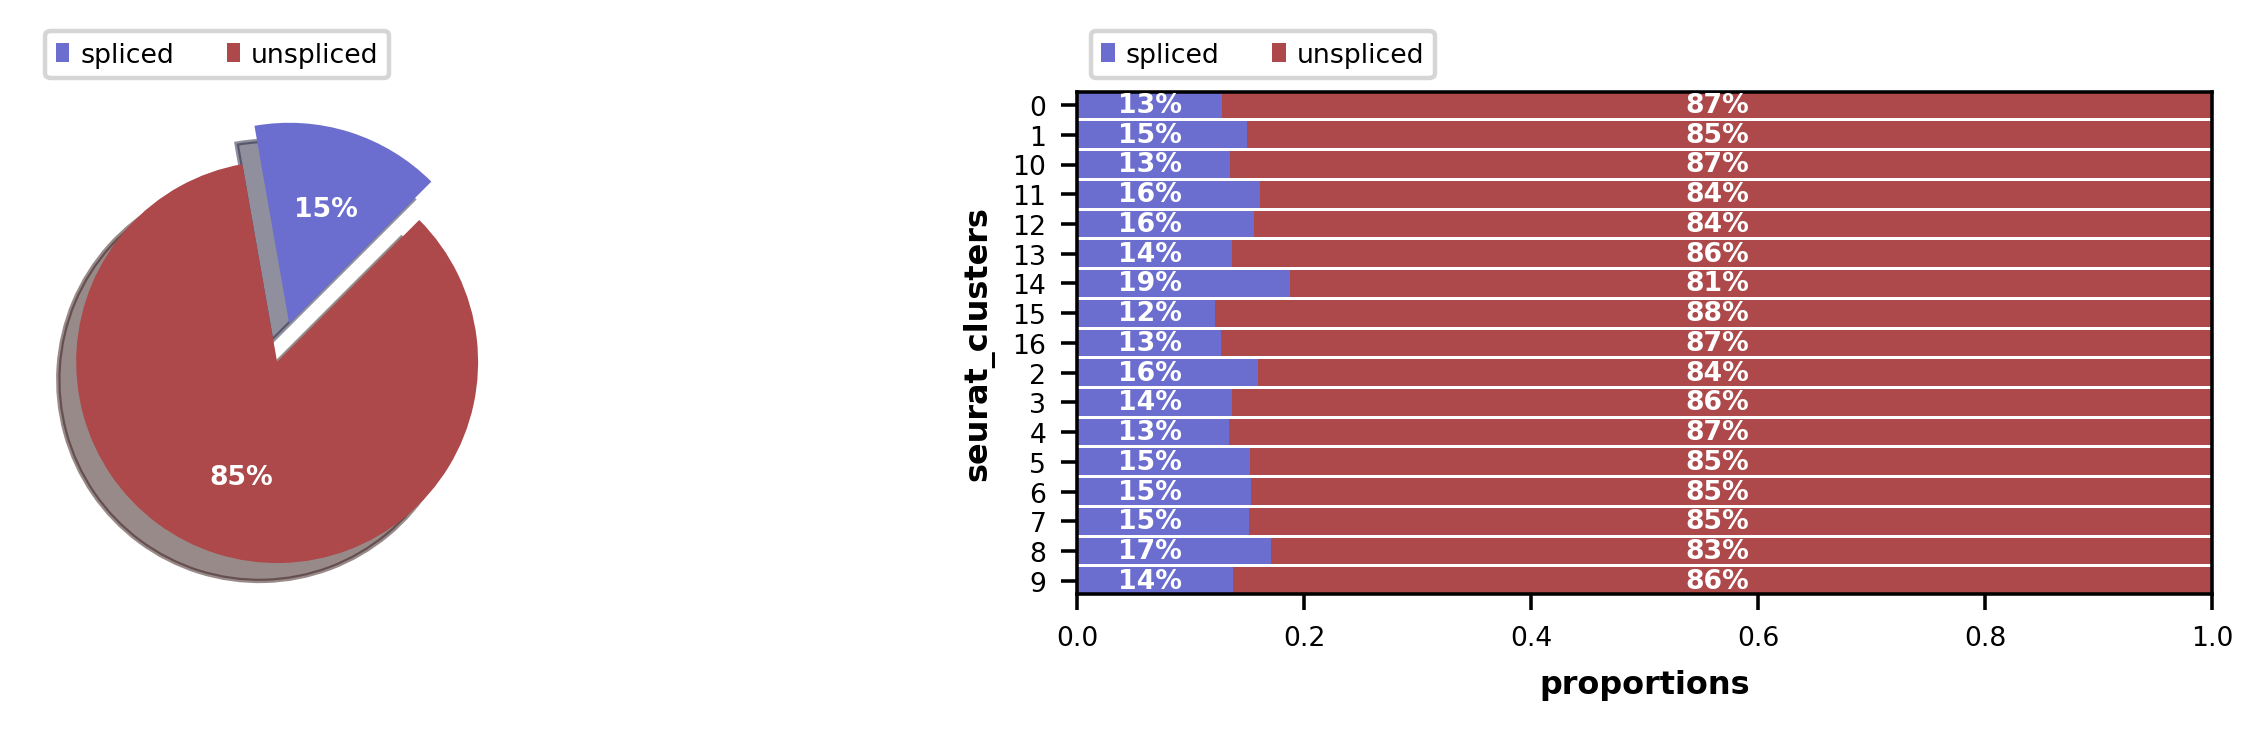

In [17]:
## Percentage of spliced/unspliced transcripts per clusters
scv.pl.proportions(adata,groupby='seurat_clusters',dpi=160,fontsize=6)

In [18]:
## Gene filtering by Minimum number of counts (both unspliced and spliced) required for a gene set to 20.
scv.pp.filter_genes(adata, min_shared_counts = 10)   ## reducted from 30 to 10 

Filtered out 26214 genes that are detected 10 counts (shared).


In [19]:
## Normalize each cell by total counts over all genes. (library size normalization)
scv.pp.normalize_per_cell(adata, enforce = True)

Normalized count data: X, spliced, unspliced.


In [ ]:
##Extracting  highly variable genes. 
#Log-scale the matrices : log(𝑋 + 1), where log denotes the natural logarithm.
#Computes moments for velocity estimation. First- and second-order moments are computed for each cell across its nearest neighbors, where the neighbor
   #graph is obtained from euclidean distances in PCA space.
    
scv.pp.filter_genes_dispersion(adata, n_top_genes = 2000)
scv.pp.log1p(adata)
scv.pp.moments(adata, n_pcs = 30, n_neighbors = 30)

computing neighbors


R[write to console]: 
 *** caught segfault ***

R[write to console]: address 0xfffffffffffffff7, cause 'memory not mapped'

R[write to console]: 
Possible actions:
1: abort (with core dump, if enabled)
2: normal R exit
3: exit R without saving workspace
4: exit R saving workspace



In [ ]:
scv.tl.recover_dynamics(adata)

In [ ]:
## Estimating velocities in a gene-specific manner.

scv.tl.velocity(adata, mode = 'dynamical')

In [ ]:
## Computing velocity graph based on cosine similarities.
scv.tl.velocity_graph(adata)

In [ ]:

#UMAP figure
%matplotlib inline
scv.pl.velocity_embedding_stream(adata, basis='X_umap',color="seurat_clusters",dpi=150,size=10)

In [ ]:
scv.pl.velocity_embedding_grid(adata, arrow_length=5, arrow_size=2, basis='X_umap',dpi=120,color="seurat_clusters")

In [ ]:

#TSNE figure
scv.pl.velocity_embedding_stream(adata,basis='X_tsne',color="seurat_clusters",dpi=120)

In [ ]:

#TSNE figure
scv.pl.velocity_embedding_grid(adata, arrow_length=5, arrow_size=2,basis='X_tsne',color="seurat_clusters",dpi=120)